In [1]:
println(Threads.nthreads())
JC_path = abspath("./src/")
if !(JC_path in LOAD_PATH)
    push!(LOAD_PATH, JC_path)
end

6


4-element Vector{String}:
 "@"
 "@v#.#"
 "@stdlib"
 "/Users/kaidongpeng/Documents/Al Floquet TWPA measurements/08-26-2022 Cooldown/code/src/"

In [2]:
using Revise
using Plots
using MAT
using JosephsonCircuits
using Plots.Measures
using Random
using SpecialFunctions
using Measures
using Printf
using ProgressBars
using Pickle
using Dates
using Distributions

# Common Utils

In [3]:
const pH = 1e-12
const fF = 1e-15
const pF = 1e-12
const uA = 1e-6
const nH = 1e-9
const nA = 1e-9
const GHz = 1e9
const MHz = 1e6
const kHz = 1e3
const Hz = 1
const wscale = 2 * pi * 1e9
const um = 1e-6
const nm = 1e-9

function dict2tuple(dict::Dict{String,Any})
    return (; (Symbol(k) => v for (k,v) in dict)...)
end

function tuple2dict(tp::NamedTuple)
    return Dict(pairs(tp))
end

"""
    to_dB(val)
Converts from linear scale to dB scale.
"""
function to_dB(val::Number)
    return 10 * log10(abs2(val))
end


"""
    from_dB(val)
Converts from dB scale to linear scale (abs).
"""
function from_dB(val::Number)
    return 10^(val/20)
end

"""
    I0_to_Lj(I0)
converts I0 (Ampere) to Lj (H).
"""
function I0_to_Lj(I0::Number)
    phi0 = 3.29105964e-16
    return phi0 / I0
end


"""
    Lj_to_I0(I0)
converts I0 (Ampere) to Lj (H).
"""
function Lj_to_I0(Lj::Number)
    phi0 = 3.29105964e-16
    return phi0 / Lj
end


"""
    ideal_qe(g)
calculate the quantum efficiency of an ideal two-mode phase-preserving amplifier at
linear amplitude gain g. if abs(g) <= 1, it is set to 1, corresponding to the situation
of perfect or noiseless frequency conversion.
"""
function ideal_qe(g::Number)
    if abs(g) <= 1
        return 1.0
    end
    return abs2(g) / (2 * abs2(g) - 1)
end


function modified_gauss_func(devlen::Number, x::Number, factor::Number=1, plateau::Number = 0.0)
    @assert plateau <= 1.0
    @assert plateau >= 0.0
    
    xcenter = (devlen+1) / 2
    pt_lo = xcenter - ((devlen-1)  * plateau / 2)
    pt_hi = xcenter + ((devlen-1)  * plateau / 2)
    if x < pt_lo
        return exp(-(x-pt_lo)^2 / (pt_lo)^2 * factor)
    end
    if x > pt_hi
        return exp(-(x-pt_hi)^2 / (pt_lo)^2 * factor) # not a typo
    end
    return 1.0 # within the plateau
end

function modified_gauss_deriv_func(devlen::Number, x::Number, factor::Number=1, plateau::Number=0.0)
    @assert plateau <= 1.0
    @assert plateau >= 0.0
    
    
    xcenter = (devlen+1) / 2
    pt_lo = xcenter - ((devlen-1)  * plateau / 2)
    pt_hi = xcenter + ((devlen-1)  * plateau / 2)
    
    if x < pt_lo
        return (- 2 *(x-pt_lo) / pt_lo^2 * factor) * exp(-(x-pt_lo)^2 / pt_lo^2 * factor)
    end
    if x > pt_hi
        return (- 2 *(x-pt_hi) / pt_lo^2 * factor) * exp(-(x-pt_hi)^2 / pt_lo^2 * factor) # not a typo
    end
    return 0.0 # within the plateau        
end

plotconfigs = Dict(
    :line => (0.8,2),
    :framestyle => :box,
#     :legend=>:outerright,
#     :marker=>:circ,
#     :markersize=>2.5,
    :xtickfontsize=>14,
    :ytickfontsize=>14,
    :yguidefontsize=>16,
    :xguidefontsize=>16,
    :legendfontsize=>10,
    :fontfamily=>"sans-serif",
    :palette=> :Dark2_8
)

subplotconfigs = Dict(
    :line => (0.8,2),
    :framestyle => :box,
#     :legend=>:outerright,
#     :marker=>:circ,
#     :markersize=>2.5,
    :xtickfontsize=>8,
    :ytickfontsize=>8,
    :yguidefontsize=>10,
    :xguidefontsize=>10,
    :legendfontsize=>8,
    :fontfamily=>"sans-serif",
    :palette=> :Dark2_8,
    :size=> (2000,1200),
    :left_margin => 15mm, 
    :bottom_margin => 15mm, 
)

Dict{Symbol, Any} with 12 entries:
  :framestyle     => :box
  :ytickfontsize  => 8
  :size           => (2000, 1200)
  :left_margin    => 15.0mm
  :yguidefontsize => 10
  :line           => (0.8, 2)
  :palette        => :Dark2_8
  :xguidefontsize => 10
  :legendfontsize => 8
  :xtickfontsize  => 8
  :bottom_margin  => 15.0mm
  :fontfamily     => "sans-serif"

In [4]:
plotconfigs = Dict(
    :line => (0.8,1.2),
    :framestyle => :box,
#     :legend=>:outerright,
#     :marker=>:circ,
#     :markersize=>2.5,
    :xtickfontsize=>12,
    :ytickfontsize=>12,
    :yguidefontsize=>14,
    :xguidefontsize=>14,
    :legendfontsize=>10,
    :fontfamily=>"sans-serif",
#     :background_color => :transparent,
#     :foreground_color => :black
#     :palette=> :tab20
)

Dict{Symbol, Any} with 8 entries:
  :line           => (0.8, 1.2)
  :yguidefontsize => 14
  :framestyle     => :box
  :xguidefontsize => 14
  :ytickfontsize  => 12
  :legendfontsize => 10
  :xtickfontsize  => 12
  :fontfamily     => "sans-serif"

# General TWPA Constructino Utils

In [5]:
function assemble_meander_params(ulist, vlist, pmrpitch, vspacing; nsupercells_v::Integer=1, start_offset=0)
    finalist = deepcopy(ulist)
    devlen = length(finalist)
    nsupercell = devlen ÷ pmrpitch
    for scidx in 1:nsupercell
        if !(mod(start_offset + scidx-1,vspacing) in collect(vspacing-nsupercells_v:vspacing-1))
            continue
        end
        for ucidx in 1:pmrpitch
            finalist[(scidx-1)*pmrpitch+ucidx] = vlist[(scidx-1)*pmrpitch+ucidx]
        end
    end
    return finalist
end
# print(assemble_meander_params(collect(1:100), collect(zeros(100)), 5, 5; nsupercells_v=2,start_offset=4))

function generate_left_right_half_params(vals)
    dtype = all(typeof.(collect(vals)) .<: Real) ? Float64 : ComplexF64
    lvals = zeros(dtype, length(vals))
    rvals = zeros(dtype, length(vals))
    lvals[1] =  vals[1]
    rvals[end] = vals[end]
    lvals[2:end] = (vals[1:end-1] .+ vals[2:end]) ./ 2
    rvals[1:end-1] = (vals[1:end-1] .+ vals[2:end]) ./ 2
    return lvals, rvals
end

# leave out the random part for now
function generate_rpm_twpa_params(cp::Union{Dict, NamedTuple})
    @variables Ipump Rleft Rright
    circuit = Array{Tuple{String,String,String,Any},1}(undef,0)
    tand = cp[:tand]
    Ncells = cp[:Ncells]
    pmrpitch=cp[:pmrpitch]
    njjs = cp[:njjs]
    lossfactor =  1/(1 + cp[:tand] * im)

    
    @assert mod(pmrpitch, 2) == 0
    
    Lj_all = cp[:Lj_list] # this is for each JJ in the njjs
    Cj_all = cp[:Cj_list]
    Cg_all = cp[:Cg_list]
    Cr_all = cp[:Cr_list]
    Lr_all = cp[:Lr_list]
    Cc_all = cp[:Cc_list]
    
    if haskey(cp, :Lg_list)
        Lg_all = cp[:Lg_list]  
        has_Lg = true
    else
        has_Lg = false
    end
    
    if haskey(cp, :Lc_list)
        Lc_all = cp[:Lc_list]    
        has_Lc = true
    else
        has_Lc = false
    end
    
    if haskey(cp, :Lsp_list)
        Lsp_all = cp[:Lsp_list]    
        has_Lsp = true
    else
        has_Lsp = false
    end
    
    if haskey(cp, :Cgr_list)
        Cgr_all = cp[:Cgr_list]    
    else
        Cgr_all = cp[:Cg_list] .- cp[:Cc_list]
    end
    
    if haskey(cp, :pmrcutoff)
        pmrcutoff = cp[:pmrcutoff]
        Ljweights = cp[:Ljweights]
        has_pmrcutoff = true
    else
        has_pmrcutoff = false
    end
    
    
    
    cellnodes = []
    
    # jjidx_curr means the idx of the left node of the current JJ
    # nodeidx_curr means the last used nodeidx (excluding gnd)
    gndidx = 0
    nodeidx_curr = 1
    jjidx_curr = 1
    ## setting up the left port
    push!(circuit,("P$(nodeidx_curr)_$(gndidx)","$(nodeidx_curr)","$(gndidx)", 1))
    push!(circuit,("I$(nodeidx_curr)_$(gndidx)","$(nodeidx_curr)","$(gndidx)", Ipump))
    push!(circuit,("R$(nodeidx_curr)_$(gndidx)","$(nodeidx_curr)","$(gndidx)", Rleft))
    
#     Lj_curr = Lj_all[1]
#     Cj_curr = Cj_all[1]
#     Cg_curr = Cg_all[1] / 2
#     Lg_curr = Lg_all[1] # todo have to think about this carefully, now assume Lg is for one stub
    

    ### main TWPA structure
    for n=1:(Ncells*njjs)
        neff = Int(ceil(n/njjs)) # index of unit cell 
        
        ## assign circuit parameter values
        Lj_curr = Lj_all[neff]
        Cj_curr = Cj_all[neff] * lossfactor
        Lr_curr = Lr_all[neff]
        Cr_curr = Cr_all[neff] * lossfactor
        if has_Lc
            Lc_curr = Lc_all[neff] 
        end
        
        if has_Lsp
            if neff == 1
                Lsp_curr = Lsp_all[1] / 2 
            else
                Lsp_curr = (Lsp_all[neff] + Lsp_all[neff-1]) / 2
            end
        end
            
        if neff == 1
            Cg_curr = Cg_all[neff] / 2 * lossfactor
            Cc_curr = Cc_all[neff] / 2 * lossfactor
            Cgr_curr = Cgr_all[neff] / 2 * lossfactor
            # todo have to think about this carefully, now assume Lg is for one stub
            if has_Lg
                Lg_curr = Lg_all[neff] 
            end
        else
            Cg_curr = (Cg_all[neff] + Cg_all[neff-1]) / 2 * lossfactor
            Cc_curr = (Cc_all[neff] + Cc_all[neff-1]) / 2 * lossfactor
            Cgr_curr = (Cgr_all[neff] + Cgr_all[neff-1]) / 2 * lossfactor
            # todo have to think about this carefully, now assume Lg is for one stub
            if has_Lg
                Lg_curr = 1 / (1 / Lg_all[neff] + 1 / Lg_all[neff-1])
            end
        end


        # apply pmrcutoff check
        if has_pmrcutoff && Ljweights[neff] < pmrcutoff
            do_pmrcutoff = true
        else 
            do_pmrcutoff = false
        end
        
        insert_pmr_curr = (mod(neff-1,pmrpitch) == pmrpitch÷2)
        if insert_pmr_curr && (!do_pmrcutoff)
            #Cg_curr -= Cc_curr
            Cg_curr = Cgr_curr
            # TODO adjust Lg value too 
        end
        
        
        ## add circuit elements
        push!(cellnodes, jjidx_curr)
        # add Cg and Lg if at cell idx
        if mod(n-1, njjs) == 0
            if has_Lg
                push!(circuit,("C$(jjidx_curr)_$(nodeidx_curr+1)","$(jjidx_curr)","$(nodeidx_curr+1)", Cg_curr))
                push!(circuit,("L$(nodeidx_curr+1)_$(gndidx)","$(nodeidx_curr+1)","$(gndidx)", Lg_curr))
                nodeidx_curr += 1
            else
                push!(circuit,("C$(jjidx_curr)_$(gndidx)","$(jjidx_curr)","$(gndidx)", Cg_curr))
            end
            
            if insert_pmr_curr && real(Cc_curr) > 0 && (!do_pmrcutoff)
                push!(circuit,("C$(jjidx_curr)_$(nodeidx_curr+1)","$(jjidx_curr)","$(nodeidx_curr+1)", Cc_curr))
                nodeidx_curr += 1
                if has_Lc
                    push!(circuit,("L$(nodeidx_curr)_$(nodeidx_curr+1)","$(nodeidx_curr)","$(nodeidx_curr+1)", Lc_curr))
                    nodeidx_curr += 1
                end
                push!(circuit,("C$(nodeidx_curr)_$(gndidx)","$(nodeidx_curr)","$(gndidx)", Cr_curr))
                push!(circuit,("L$(nodeidx_curr)_$(gndidx)","$(nodeidx_curr)","$(gndidx)", Lr_curr)) 
            end
        end
        
        # first add Lsp is specified
        
        if has_Lsp && mod(n-1, njjs) == 0
            push!(circuit,("Ls$(jjidx_curr)_$(nodeidx_curr+1)","$(jjidx_curr)","$(nodeidx_curr+1)", Lsp_curr))
            nodeidx_curr += 1
            jjidx_curr = nodeidx_curr
        end

        # add JJ
        push!(circuit,("Lj$(jjidx_curr)_$(nodeidx_curr+1)","$(jjidx_curr)","$(nodeidx_curr+1)", Lj_curr))
        push!(circuit,("C$(jjidx_curr)_$(nodeidx_curr+1)","$(jjidx_curr)","$(nodeidx_curr+1)", Cj_curr))
        nodeidx_curr += 1
        
        # record node and update jjidx_curr
        # push!(cellnodes, jjidx_curr)
        jjidx_curr = nodeidx_curr
        
    end
    
    # add the last half Lsp if it exists
    if has_Lsp
        push!(circuit,("Ls$(jjidx_curr)_$(nodeidx_curr+1)","$(jjidx_curr)","$(nodeidx_curr+1)", Lsp_all[Ncells]/2))
        jjidx_curr += 1
        nodeidx_curr += 1
    end

    
    # the right port and last capacitors. we won't add PMR at the boundary
    push!(circuit,("P$(jjidx_curr)_$(gndidx)","$(jjidx_curr)","$(gndidx)", 2))
    push!(circuit,("I$(jjidx_curr)_$(gndidx)","$(jjidx_curr)","$(gndidx)", Ipump))
    push!(circuit,("R$(jjidx_curr)_$(gndidx)","$(jjidx_curr)","$(gndidx)", Rright))
    push!(cellnodes, jjidx_curr)

    Cg_curr = Cg_all[Ncells] / 2
    if has_Lg
        Lg_curr = Lg_all[Ncells] # todo have to think about this carefully, now assume Lg is for one stub
    end
    
    if has_Lg
        push!(circuit,("C$(jjidx_curr)_$(nodeidx_curr+1)","$(jjidx_curr)","$(nodeidx_curr+1)", Cg_curr))
        push!(circuit,("L$(nodeidx_curr+1)_$(gndidx)","$(nodeidx_curr+1)","$(gndidx)", Lg_curr))
    else
        push!(circuit,("C$(jjidx_curr)_$(gndidx)","$(jjidx_curr)","$(gndidx)", Cg_curr))
    end
    return circuit, cellnodes
end

generate_rpm_twpa_params (generic function with 1 method)

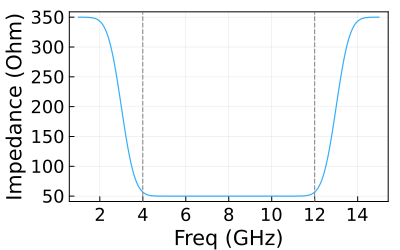

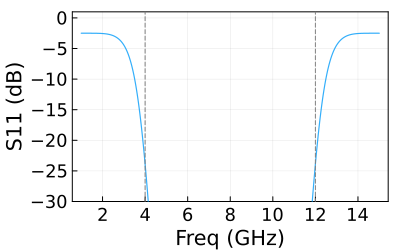

In [6]:
function unwrap!(p)
    length(p) < 2 && return p
    for i = 2:length(p)
        d = p[i] - p[i-1]
        if abs(d) > pi
            p[i] -= floor((d+pi) / (2pi)) * 2pi
        end
    end
    return p
end

function quantize_dimension(vals, minstep; digits=5)
    return round.(round.(Int, vals ./ minstep) .* minstep, digits=digits)
end

function cgauss(x; mu=0.0, sigma = 1.0)
    return cdf(Normal(mu, sigma), x)

end

function oobZfunc(wcenter, wwidth, Zib, Zoob; widthfactor=1)
    
    return (function(w)
        w = abs(w)
        if w < wcenter
            wedge = wcenter - wwidth/2
            return Zoob + (Zib - Zoob) * cgauss((w-wedge)/wwidth, sigma=widthfactor)
        else
            wedge = wcenter + wwidth/2
            return Zoob + (Zib - Zoob) * cgauss((wedge-w)/wwidth, sigma=widthfactor)
        end    
    end)
    
#     return w-> cgauss((abs(w-wcenter)/wwidth, sigma =  widthfactor)
end

wvals = collect(1:0.01:15) .* wscale
zfunc = oobZfunc(8 * wscale, 10 * wscale, 50, 350; widthfactor=.05)
Zplt = plot(size=(400,250));
plot!(Zplt, wvals ./ wscale, zfunc.(wvals),xlabel="Freq (GHz)", ylabel="Impedance (Ohm)",label=nothing;plotconfigs...)
plot!(Zplt, [4], seriestype=:vline,ls=:dash,c="gray",label=nothing)
plot!(Zplt, [12], seriestype=:vline,ls=:dash,c="gray",label=nothing)
display(Zplt)

Splt = plot(size=(400,250));
plot!(Splt, wvals ./ wscale, to_dB.((zfunc.(wvals) .- 50) ./ (zfunc.(wvals) .+ 50)),xlabel="Freq (GHz)",
    ylabel="S11 (dB)",label=nothing,ylim=(-30,1),yticks=-30:5:0;plotconfigs...)
plot!(Splt, [4], seriestype=:vline,ls=:dash,c="gray",label=nothing)
plot!(Splt, [12], seriestype=:vline,ls=:dash,c="gray",label=nothing)
display(Splt)


# import experimental data

In [7]:
file = matopen("../data/floquet_twpa_gain_spectrum_7.620GHz_7.20dBm_2022-09-01_18_00_03.mat");
# varnames = keys(file)
# println(varnames)
drivendata = read(file, "drivendata");
undrivendata = read(file, "undrivendata");
thru = read(file, "thru")
sigfreqs = read(file, "sigfreqs");
# close(file)

ildata_fine = matread("../data/Floquet_TWPA_probe_power_sweep_1601pts_2022-09-02_11_00_22_data.mat");

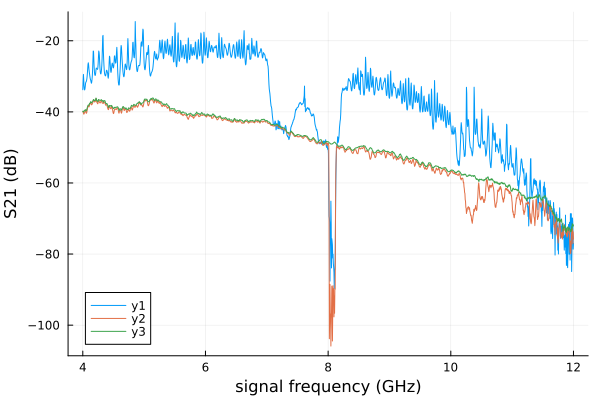

In [8]:
plot(sigfreqs[:]/1e9,10*log10.(abs2.(drivendata[:])),
    xlabel="signal frequency (GHz)",ylabel="S21 (dB)")
plot!(sigfreqs[:]/1e9,10*log10.(abs2.(undrivendata[:])))
plot!(sigfreqs[:]/1e9,10*log10.(abs2.(thru[:])))

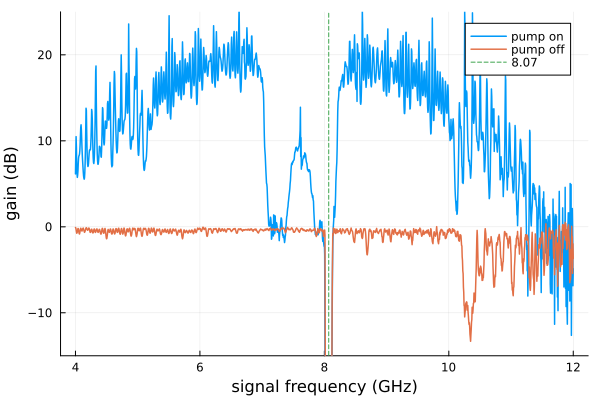

In [9]:
plot(sigfreqs[:]/1.0e9,
    10*log10.(abs2.(drivendata[:]./thru[:])),
    label="pump on",
    legend=:topright,
    linewidth=1.5,
    xlabel="signal frequency (GHz)",
    ylabel="gain (dB)",
#     aspect_ratio = 0.08,
#     aspect_ratio = 0.3,
    ylim= (-15,25),
#     xlim=(4.0,10)
    ;
    )
plot!(sigfreqs[:]/1.0e9,
    10*log10.(abs2.(undrivendata[:]./thru[:])),
    label="pump off",
    linewidth = 1.5)

vval = 8.07
plot!([vval],seriestype=:vline,ls=:dash, label=string(vval))

# Theory modeling

In [10]:
Lsu = 26.154e-12
Cgu_x0 = 16.3204e-15
Cgu_x1 = 3.53337e-10

Lsv = 34.116e-12
Cgv_x0 = 21.09e-15
Cgv_x1 = 3.60848e-10

function Cgu2len(Cgu)
    return (Cgu - Cgu_x0) / Cgu_x1
end

function len2Cgu(Cglen)
    return (Cgu_x0 + Cgu_x1 * Cglen)
end

function Cgv2len(Cgv)
    return (Cgv - Cgv_x0) / Cgv_x1
end

function len2Cgv(Cglen)
    return (Cgv_x0 + Cgv_x1 * Cglen)
end


Ccp=1e-15
Ccl = 0.187e-15
Cc2len = (Cc) -> Cc==0 ? 0 : (Cc - Ccp) / Ccl
Ccu2len = Cc2len
Ccv2len = Cc2len
len2Cc = (Cclen) -> (Ccp + Ccl * Cclen)


Cgr2len = (cgr)-> (cgr - 16.028e-15) / 1.1099e-16
len2Cgr =  (len)-> 1.1099e-16 * len + 16.028e-15




#15 (generic function with 1 method)

In [43]:
using Pickle
porig = Pickle.load("../data/2022-01-19_al_floquet_twpa_simulation_params.pkl");

gdsconfig = Pickle.load("../data/2022-04-23_al_floquet_twpa_gds_params_2870_Z50d00_Jc_13.00.pkl");
println(keys(gdsconfig))

Any["Cgrnvals_u_right", "Cglen0", "JJlengths", "Ccnvals_v", "Jc", "Cclen0", "Cglens_v", "JJlengths2", "Cglens_u", "Cclens_v", "Cgnvals_v", "Cgrlens_v_left", "ncells", "Ccnvals_u", "Cclens_u", "Cgrlens_v_right", "Cgrlens_u_left", "Cgrnvals_v_right", "Cgnvals_u", "JJlength0", "Cgrnvals_v_left", "Cgrnvals_u_left", "Ljnvals", "Cgrlens_u_right"]


### extract circuit paramters from gdsconfig

In [24]:
length(gdsconfig["JJlengths"])

2870

In [82]:
cp_aftv1 = Dict()
cp_aftv1[:Jcnominal] = 13e-6
cp_aftv1[:JJ_overlap] = 0.2
cp_aftv1[:njjs] = 3
cp_aftv1[:tand] = 0
cp_aftv1[:Ncells] = length(gdsconfig["JJlengths"])
cp_aftv1[:pmrpitch] = 10
cp_aftv1[:csj] = 67e-15 # csj_func(cp_aftv2[:Jc]) * 1

cp_aftv1[:Cr] = 640e-15 
cp_aftv1[:Lr] = 560e-12 
cp_aftv1[:pmrcutoff] = 0.5
cp_aftv1[:vspacing] = 6 
cp_aftv1[:nsupercells_v] = 1
cp_aftv1[:start_offset] =  3 
cp_aftv1[:JJlen_minstep] = 0.005

Jcfactor = 1
simplify_sim = true


cp_aftv1[:Lj_list] = I0_to_Lj.(gdsconfig["JJlengths"] .* cp_aftv1[:JJ_overlap] .* cp_aftv1[:Jcnominal])
cp_aftv1[:Ic_list] = Lj_to_I0.(cp_aftv1[:Lj_list]);
cp_aftv1[:Cj_list] = cp_aftv1[:csj]  .* gdsconfig["JJlengths"] .* cp_aftv1[:JJ_overlap];
aftv1_weights = cp_aftv1[:Lj_list] ./ maximum(cp_aftv1[:Lj_list])

cp_aftv1[:Cr_list] = [cp_aftv1[:Cr] for _ in 1:cp_aftv1[:Ncells]]
cp_aftv1[:Lr_list] = [cp_aftv1[:Lr] for _ in 1:cp_aftv1[:Ncells]]

Cguvals = len2Cgu.(gdsconfig["Cglens_u"] .* um)
Cgvvals = len2Cgu.(gdsconfig["Cglens_v"] .* um)

Ccuvals = len2Cc.(gdsconfig["Cclens_u"] .* um)
Ccvvals = len2Cc.(gdsconfig["Cclens_v"] .* um)

for idx in 1:length(aftv1_weights)
    if aftv1_weights[idx] <= cp_aftv1[:pmrcutoff]
        Ccuvals[idx] = 0
        Ccvvals[idx] = 0
        continue
    end
end

cp_aftv1[:Cg_list] = assemble_meander_params(Cguvals, Cgvvals, cp_aftv1[:pmrpitch], cp_aftv1[:vspacing];
    nsupercells_v=cp_aftv1[:nsupercells_v], start_offset=cp_aftv1[:start_offset])
cp_aftv1[:Cc_list] = assemble_meander_params(Ccuvals, Ccvvals, cp_aftv1[:pmrpitch], cp_aftv1[:vspacing];
    nsupercells_v=cp_aftv1[:nsupercells_v], start_offset=cp_aftv1[:start_offset])



# TODO 
["Cgrlens_v_left", "ncells",
"Ccnvals_u", "Cclens_u", "Cgrlens_v_right", "Cgrlens_u_left",
"Cgrnvals_v_right", "Cgnvals_u", "JJlength0",
"Cgrnvals_v_left", "Cgrnvals_u_left", "Ljnvals", "Cgrlens_u_right"]

Cgrlens_u = gdsconfig["Cgrlens_u_left"]
Cgrlens_u[end] = gdsconfig["Cgrlens_u_right"][end]
Cgrlens_v = gdsconfig["Cgrlens_v_left"]
Cgrlens_v[end] = gdsconfig["Cgrlens_v_right"][end]
# Cgrfactor = 0.3
# Cgruvals = p["Cg_pmr_u_raw_left"] .+ p["Cgr"]

Cgruvals = len2Cgr.(Cgrlens_u .* um)
Cgrvvals = len2Cgr.(Cgrlens_v .* um)

cp_aftv1[:Cgr_list] = assemble_meander_params(Cgruvals, Cgrvvals, cp_aftv1[:pmrpitch], cp_aftv1[:vspacing];
    nsupercells_v=cp_aftv1[:nsupercells_v], start_offset=cp_aftv1[:start_offset])




2870-element Vector{Float64}:
 1.602800303803269e-14
 1.6028003055009302e-14
 1.6028003072042794e-14
 1.602800308058096e-14
 1.6028003097700315e-14
 1.6028003114877278e-14
 1.602800313211214e-14
 1.60280031494052e-14
 1.6028003158073645e-14
 1.6028003175454554e-14
 1.602800319289441e-14
 1.602800321039351e-14
 1.6028003219165374e-14
 ⋮
 1.602800321039351e-14
 1.602800319289441e-14
 1.6028003175454554e-14
 1.6028003158073645e-14
 1.60280031494052e-14
 1.602800313211214e-14
 1.6028003114877278e-14
 1.6028003097700315e-14
 1.602800308058096e-14
 1.6028003072042794e-14
 1.6028003055009302e-14
 1.602800303803269e-14

In [123]:
# define the circuit components
# circuit = []


p = deepcopy(porig)
p["Cgvals_raw_u"] = Cguvals
p["Cgvals_raw_v"] = Cgvvals

p["Lsu"] = Lsu
p["Lsv"] = Lsv
p["njjs"] = cp_aftv1[:njjs]
p["Ljvals_raw"] = cp_aftv1[:Lj_list]
p["Cjvals_raw"] = cp_aftv1[:Cj_list]
p["start_offset"] = cp_aftv1[:start_offset]

p["Lr"] = cp_aftv1[:Lr]
p["Cr"] =  cp_aftv1[:Cr]
p["L"] = cp_aftv1[:Ncells]

circuit = Tuple{String,String,String,Num}[]

tandelta= 0#1e-5
Ljscale = 1.1 # 1.15
Cscale = 1.052 #/(1+im*tandelta)
Cgrscale = 0.25 #/(1+im*tandelta)
Cjscale = 3.56 # 4.0 # 2.0 # /(1+im*tandelta)

@variables Ipump Rleft Rright

# port on the left side
push!(circuit,("P$(1)_$(0)","1","0",1))
push!(circuit,("R$(1)_$(0)","1","0",Rleft))
Nj=p["L"]


# Nj=600
# use 8000 to get rid of the pmrs
pmrpitch = p["spacing"]
# pmrpitch = 16000
#first half cap to ground
push!(circuit,("Cg$(1)_$(0)","1","0",Cscale*p["Cgvals_raw_u"][1]/2))
#middle caps and jj's
push!(circuit,("Ls$(1)_$(2)","1","2",p["Lsu"]/2)) 
push!(circuit,("Lj$(2)_$(3)","2","3",Ljscale*p["Ljvals_raw"][1])) 
push!(circuit,("Lj$(3)_$(4)","3","4",Ljscale*p["Ljvals_raw"][1])) 
push!(circuit,("Lj$(4)_$(5)","4","5",Ljscale*p["Ljvals_raw"][1])) 

j=5
for i = 2:Nj-1

    superidx = (i ÷ pmrpitch) + p["start_offset"] 
    
    if superidx % p["vspacing"] == 0
        Ls = p["Lsv"]
        Cc = p["Cc_raw_v_between_left"][i]
        Cg = p["Cgvals_raw_v"][i]
        Cg_pmr = p["Cg_pmr_v_raw_left"][i]

    else
        Ls = p["Lsu"]
        Cc = p["Cc_raw_u_between_left"][i]
        Cg = p["Cgvals_raw_u"][i]
        Cg_pmr = p["Cg_pmr_u_raw_left"][i]
    end
    
#     if ispmr(i,pmrpitch)
    if mod(i,pmrpitch) == pmrpitch÷2 && abs(Cc) > 0

        # series linear inductor
        push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",Ls/2)) 
        
        # make the jj cell with modified capacitance to ground
        push!(circuit,("Cgr$(j+1)_$(0)","$(j+1)","$(0)",Cscale*Cg_pmr+Cgrscale*Cscale*p["Cgr"]))
        
        # series linear inductor
        push!(circuit,("Ls$(j+1)_$(j+2)","$(j+1)","$(j+2)",Ls/2)) 
        
        # make the pmr
        # coupling capacitor
        push!(circuit,("Cc$(j+2)_$(j+3)","$(j+2)","$(j+3)",Cscale*Cc))
        
        # series inductor
        push!(circuit,("Lc$(j+3)_$(j+4)","$(j+3)","$(j+4)",p["Lc"]))
        push!(circuit,("Cr$(j+4)_$(0)","$(j+4)","$(0)",Cscale*p["Cr"]))
        push!(circuit,("Lr$(j+4)_$(0)","$(j+4)","$(0)",p["Lr"]))
        
        # make the junctions
        push!(circuit,("Lj$(j+2)_$(j+5)","$(j+2)","$(j+5)",Ljscale*p["Ljvals_raw"][i] * p["njjs"])) 
        # make the junction capacitors
        push!(circuit,("Cj$(j+2)_$(j+5)","$(j+2)","$(j+5)",Cjscale*p["Cjvals_raw"][i]/ p["njjs"]) ) 
        
        # increment the index by two because of the 2
        # pmr nodes.
        j+=2
    else
        
        # series linear inductor
        push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",Ls/2)) 

        # add capacitance to ground
        push!(circuit,("Cg$(j+1)_$(0)","$(j+1)","$(0)",Cscale*Cg))

        # series linear inductor
        push!(circuit,("Ls$(j+1)_$(j+2)","$(j+1)","$(j+2)",Ls/2)) 
        
        # add JJ
        push!(circuit,("Lj$(j+2)_$(j+3)","$(j+2)","$(j+3)",Ljscale*p["Ljvals_raw"][i]* p["njjs"]))

        # add the junction capacitance
        push!(circuit,("Cj$(j+2)_$(j+3)","$(j+2)","$(j+3)",Cjscale*p["Cjvals_raw"][i]/ p["njjs"])) 

    end
    # increment the index
    j+=3

end

#last jj
push!(circuit,("Cg$(j)_$(0)","$(j)","$(0)",p["Cgvals_raw_u"][end]/2))
push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",p["Lsu"]/2)) 

push!(circuit,("R$(j+1)_$(0)","$(j+1)","$(0)",Rright))
push!(circuit,("P$(j+1)_$(0)","$(j+1)","$(0)",2))

circuitdefs = Dict(
    Rleft => 60,
    Rright => 60,
)


Dict{Num, Int64} with 2 entries:
  Rright => 60
  Rleft  => 60

In [124]:
wp = 7.62 * wscale
w=(4.0:0.01:12)*wscale
Npumpmodes = 1
Nsignalmodes = 1
Ip=2.0e-6*0.0
@time pumpoff = hbsolve(w,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);


  0.404316 seconds (1.08 M allocations: 327.548 MiB)


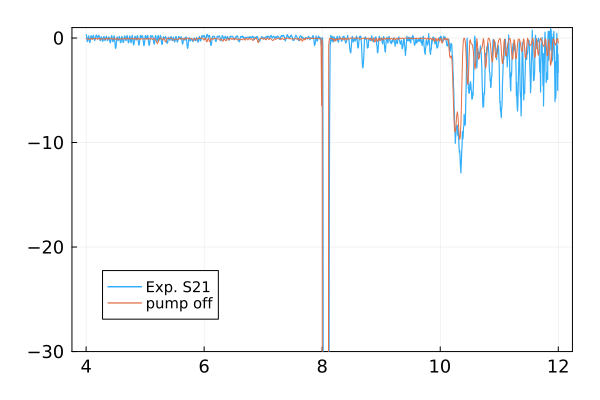

In [126]:

plot(sigfreqs[:]/1.0e9,
    0.4 .+ 10*log10.(abs2.(undrivendata[:]./thru[:])),
    label="Exp. S21",
    linewidth = 1.5,
    legend=(0.15,.2),
    margin=5mm,
#     bottom_margin=5mm,
    ;plotconfigs...)



plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,:])),
    label="pump off")

plot!(ylim=(-30,1))

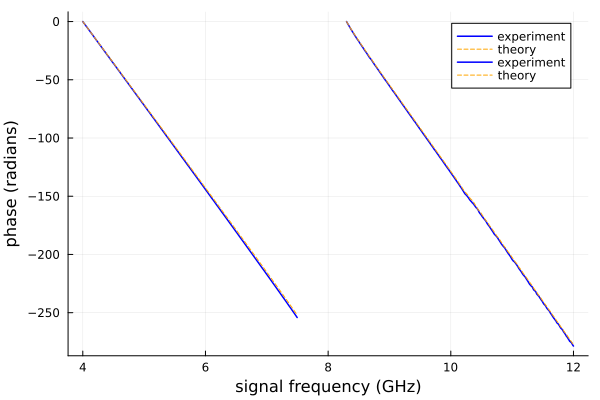

In [127]:
using DSP

plot(sigfreqs[861:end]/1.0e9,
    unwrap(angle.(undrivendata[861:end]./thru[861:end])) .- angle(undrivendata[861] / thru[861]),
    label="experiment",
    ylabel="phase (radians)", c=:blue,
    linewidth = 1.5)

plot!(w[431:end]/(2*pi*1e9),
     unwrap(angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                431:end])) .- angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                431]), ls=:dash,
    label="theory",c=:orange,
xlabel="signal frequency (GHz)")

plot!(sigfreqs[1:700]/1.0e9,
    unwrap(angle.(undrivendata[1:700]./thru[1:700])) .- angle(undrivendata[1] / thru[1]),
    label="experiment",
    ylabel="phase (radians)",c=:blue,
    linewidth = 1.5)

plot!(w[1:350]/(2*pi*1e9),
    unwrap(angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                1:350])) .- angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                1]),
    label="theory",ls=:dash,c=:orange,
xlabel="signal frequency (GHz)")

In [117]:
Npumpmodes = 6
Nsignalmodes = 6
Ip=5.0e-6 / 3 *0.3# 2.0e-6*0.69
@time pumpon = hbsolve(w,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);


norm(F)/norm(x): 1.6821847997127718e-5
 89.733972 seconds (8.59 M allocations: 59.667 GiB, 8.36% gc time, 0.36% compilation time)


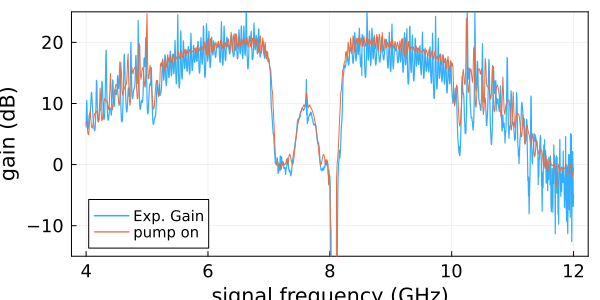

In [129]:
plot(sigfreqs[:]/1.0e9,
    10*log10.(abs2.(drivendata[:]./thru[:])),
    label="Exp. Gain",
    legend=:topright,
    linewidth=1.5,
    xlabel="signal frequency (GHz)",
    ylabel="Gain (dB)",
    ylim= (-15,25),
    size=(600,300);
    plotconfigs...
#     ylim=(-10,0.5),
#     xlim=(4,4.2),
#     xlim=(4.0,10)
    )

plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpon.signal.S[end-pumpon.signal.Nmodes+pumpon.signal.signalindex,pumpon.signal.signalindex,:])),
    ylim=(-15,25),
    xlabel="signal frequency (GHz)",
    ylabel="gain (dB)",
    label="pump on",legend=:bottomleft)

In [130]:
1.38e-23 * 2.5 / (6.636e-34 * 5e9)

10.397830018083184

In [131]:
(6.636e-34 * 5e9) / 1.38e-23 

0.24043478260869564

 13.650920 seconds (28.16 M allocations: 5.150 GiB, 4.74% gc time)
  0.293182 seconds (1.72 M allocations: 287.974 MiB)
 18.693841 seconds (4.20 M allocations: 7.966 GiB, 9.25% gc time)


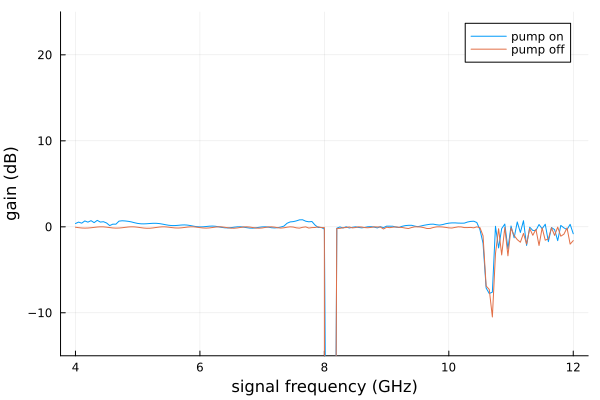

In [72]:

w=2*pi*(4.0:0.05:12)*1e9
woff = 2*pi *(6.6:0.00001:6.8)*1e9
# wp=2*pi*7.901*1e9
wp=2*pi*7.620*1e9

# w=2*pi*[6.0]*1e9
# w=2*pi*(0.1:0.1:30)*1e9

# Nsignalmodes = 1
# Npumpmodes = 1

Npumpmodes = 8
Nsignalmodes = 8
Ip=2.0e-6*0.3# 2.0e-6*0.69
@time pumpon = hbsolve(w,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);

Npumpmodes = 1
Nsignalmodes = 1
Ip=2.0e-6*0.0
@time pumpoff = hbsolve(w,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);


Npumpmodes = 1
Nsignalmodes = 1
Ip=2.0e-6*0.0
@time pumpoff_fine = hbsolve(woff,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);

plot(w/(2*pi*1e9),
    10*log10.(abs2.(pumpon.signal.S[end-pumpon.signal.Nmodes+pumpon.signal.signalindex,pumpon.signal.signalindex,:])),
    ylim=(-15,25),
    xlabel="signal frequency (GHz)",
    ylabel="gain (dB)",
    label="pump on")

plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,:])),
    label="pump off")

# plot!(w/(2*pi*1e9),
#     10*log10.(abs2.(rpm.signal.S[rpm.signal.signalindex,rpm.signal.signalindex,:])),
#     label="return loss")


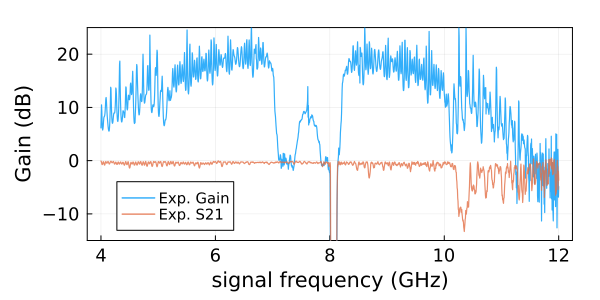

In [13]:
plot(sigfreqs[:]/1.0e9,
    10*log10.(abs2.(drivendata[:]./thru[:])),
    label="Exp. Gain",
    legend=:topright,
    linewidth=1.5,
    xlabel="signal frequency (GHz)",
    ylabel="Gain (dB)",
    ylim= (-15,25),
    size=(600,300);
    plotconfigs...
#     ylim=(-10,0.5),
#     xlim=(4,4.2),
#     xlim=(4.0,10)
    )

plot!(sigfreqs[:]/1.0e9,
    10*log10.(abs2.(undrivendata[:]./thru[:])),
    label="Exp. S21",
    linewidth = 1.5,
    legend=(0.15,.2),
    margin=5mm,
#     bottom_margin=5mm,
    ;plotconfigs...)


# savefig("Exp-Gain-Floquet-TWPA1.pdf")

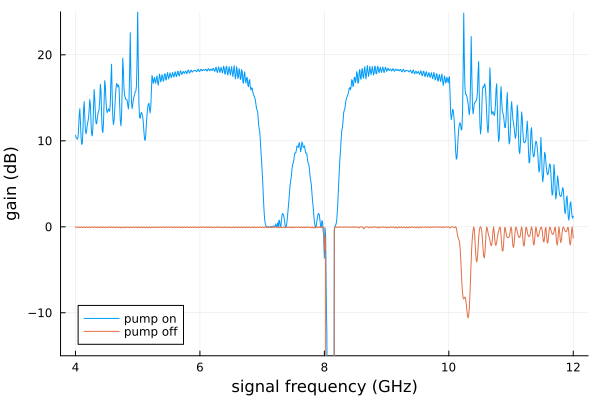

In [14]:
plot(w/(2*pi*1e9),
    10*log10.(abs2.(pumpon.signal.S[end-pumpon.signal.Nmodes+pumpon.signal.signalindex,pumpon.signal.signalindex,:])),
    ylim=(-15,25),
    xlabel="signal frequency (GHz)",
    ylabel="gain (dB)",
    label="pump on")

plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,:])),
    label="pump off")


# Plot Phase

In [ ]:
plot!(sigfreqs[:]/1.0e9,
    10*log10.(angle.(undrivendata[:]./thru[:])),
    label="pump off",
    linewidth = 1.5)

# comparison of ripple frequency

In [33]:
size(ildata_fine["sweepdata"])

(1, 16, 1601)

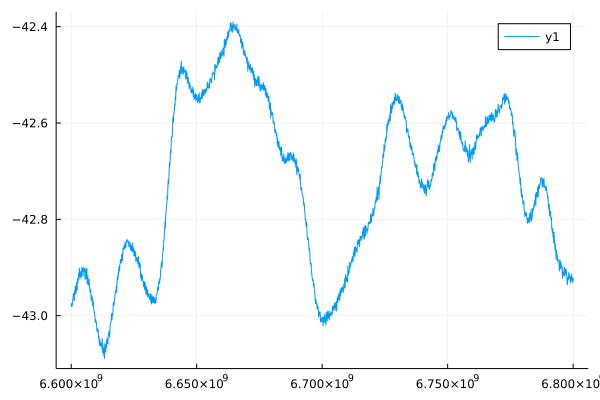

In [35]:
ildata_fine
ildata_fine["sigfreqs"][1,:]

plot(ildata_fine["sigfreqs"][1,:], 10*log10.(abs2.(ildata_fine["sweepdata"][1,16,:])))

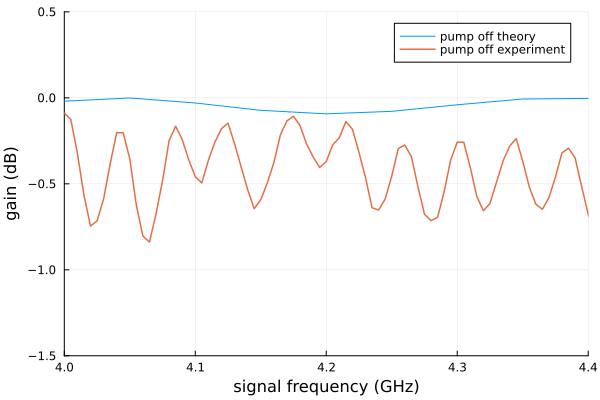

In [60]:
plot(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,:])),
    label="pump off theory",xlim=(4,4.4),ylim=(-1.5,0.5),
    ylabel="gain (dB)",xlabel="signal frequency (GHz)")

plot!(sigfreqs[:]/1.0e9,
    10*log10.(abs2.(undrivendata[:]./thru[:])),
    label="pump off experiment",
    linewidth = 1.5)



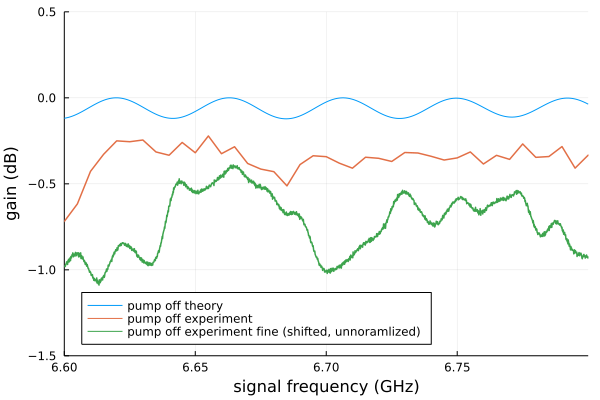

In [56]:
plot(woff/(2*pi*1e9),
    10*log10.(abs2.(pumpoff_fine.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,:])),
    label="pump off theory",xlim=(6.6,6.8),ylim=(-1.5,0.5),
    ylabel="gain (dB)",xlabel="signal frequency (GHz)")

plot!(sigfreqs[:]/1.0e9,
    10*log10.(abs2.(undrivendata[:]./thru[:])),
    label="pump off experiment",
    linewidth = 1.5)


plot!(ildata_fine["sigfreqs"][1,:]/1.0e9, 42 .+ 10*log10.(abs2.(ildata_fine["sweepdata"][1,16,:])),
    label="pump off experiment fine (shifted, unnoramlized)",linewidth = 1.5,legend=:bottomleft)
# plot!(ildata_fine["sigfreqs"][1,:]/1.0e9,
#     10*log10.(ildata_fine["sweepdata"][1,16,:]),
#     label="pump off experiment 2",
#     linewidth = 1.5)

# comparison of electrical length

In [18]:
length(undrivendata)
length(w)

801

In [34]:
sigfreqs[861] / 1e9

8.3

In [35]:
w[431] / (2 * pi * 1e9)

8.3

In [124]:
# define the circuit components
# circuit = []

circuit = Tuple{String,String,String,Num}[]

tandelta= 0#1e-5
Ljscale = 1.07 # 1.15
Cscale = 1.1 #/(1+im*tandelta)
Cgrscale = 0.3#/(1+im*tandelta)
Cjscale = 4 # 2.0 # /(1+im*tandelta)

@variables Ipump Rleft Rright

# port on the left side
push!(circuit,("P$(1)_$(0)","1","0",1))
push!(circuit,("R$(1)_$(0)","1","0",Rleft))
Nj=p["L"]


# Nj=600
# use 8000 to get rid of the pmrs
pmrpitch = p["spacing"]
# pmrpitch = 16000
#first half cap to ground
push!(circuit,("Cg$(1)_$(0)","1","0",Cscale*p["Cgvals_raw_u"][1]/2))
#middle caps and jj's
push!(circuit,("Ls$(1)_$(2)","1","2",p["Lsu"]/2)) 
push!(circuit,("Lj$(2)_$(3)","2","3",Ljscale*p["Ljvals_raw"][1])) 
push!(circuit,("Lj$(3)_$(4)","3","4",Ljscale*p["Ljvals_raw"][1])) 
push!(circuit,("Lj$(4)_$(5)","4","5",Ljscale*p["Ljvals_raw"][1])) 

j=5
for i = 2:Nj-1

    superidx = i ÷ pmrpitch
    
    if superidx % p["vspacing"] == 0
        Ls = p["Lsv"]
        Cc = p["Cc_raw_v_between_left"][i]
        Cg = p["Cgvals_raw_v"][i]
        Cg_pmr = p["Cg_pmr_v_raw_left"][i]

    else
        Ls = p["Lsu"]
        Cc = p["Cc_raw_u_between_left"][i]
        Cg = p["Cgvals_raw_u"][i]
        Cg_pmr = p["Cg_pmr_u_raw_left"][i]
    end
    
#     if ispmr(i,pmrpitch)
    if mod(i,pmrpitch) == pmrpitch÷2 && abs(Cc) > 0

        # series linear inductor
        push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",Ls/2)) 
        
        # make the jj cell with modified capacitance to ground
        push!(circuit,("Cgr$(j+1)_$(0)","$(j+1)","$(0)",Cscale*Cg_pmr+Cgrscale*Cscale*p["Cgr"]))
        
        # series linear inductor
        push!(circuit,("Ls$(j+1)_$(j+2)","$(j+1)","$(j+2)",Ls/2)) 
        
        # make the pmr
        # coupling capacitor
        push!(circuit,("Cc$(j+2)_$(j+3)","$(j+2)","$(j+3)",Cscale*Cc))
        
        # series inductor
        push!(circuit,("Lc$(j+3)_$(j+4)","$(j+3)","$(j+4)",p["Lc"]))
        push!(circuit,("Cr$(j+4)_$(0)","$(j+4)","$(0)",Cscale*p["Cr"]))
        push!(circuit,("Lr$(j+4)_$(0)","$(j+4)","$(0)",p["Lr"]))
        
        # make the junctions
        push!(circuit,("Lj$(j+2)_$(j+5)","$(j+2)","$(j+5)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+5)_$(j+6)","$(j+5)","$(j+6)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+6)_$(j+7)","$(j+6)","$(j+7)",Ljscale*p["Ljvals_raw"][i])) 

        # make the junction capacitors
        push!(circuit,("Cj$(j+2)_$(j+5)","$(j+2)","$(j+5)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+5)_$(j+6)","$(j+5)","$(j+6)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+6)_$(j+7)","$(j+6)","$(j+7)",Cjscale*p["Cjvals_raw"][i])) 
        
        # increment the index by two because of the 2
        # pmr nodes.
        j+=2
    else
        
        # series linear inductor
        push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",Ls/2)) 

        # add capacitance to ground
        push!(circuit,("Cg$(j+1)_$(0)","$(j+1)","$(0)",Cscale*Cg))

        # series linear inductor
        push!(circuit,("Ls$(j+1)_$(j+2)","$(j+1)","$(j+2)",Ls/2)) 
        
        # add JJ
        push!(circuit,("Lj$(j+2)_$(j+3)","$(j+2)","$(j+3)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+3)_$(j+4)","$(j+3)","$(j+4)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+4)_$(j+5)","$(j+4)","$(j+5)",Ljscale*p["Ljvals_raw"][i]))

        # add the junction capacitance
        push!(circuit,("Cj$(j+2)_$(j+3)","$(j+2)","$(j+3)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+3)_$(j+4)","$(j+3)","$(j+4)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+4)_$(j+5)","$(j+4)","$(j+5)",Cjscale*p["Cjvals_raw"][i]))
    end
    # increment the index
    j+=5

end

#last jj
push!(circuit,("Cg$(j)_$(0)","$(j)","$(0)",p["Cgvals_raw_u"][end]/2))
push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",p["Lsu"]/2)) 

push!(circuit,("R$(j+1)_$(0)","$(j+1)","$(0)",Rright))
push!(circuit,("P$(j+1)_$(0)","$(j+1)","$(0)",2))

circuitdefs = Dict(
    Rleft => 60,
    Rright => 60,
)


Dict{Num, Int64} with 2 entries:
  Rright => 60
  Rleft  => 60

In [125]:
w=2*pi*(4.0:0.01:12)*1e9
Npumpmodes = 1
Nsignalmodes = 1
Ip=2.0e-6*0.0
@time pumpoff = hbsolve(w,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);



  0.821731 seconds (1.81 M allocations: 541.860 MiB, 9.43% gc time)


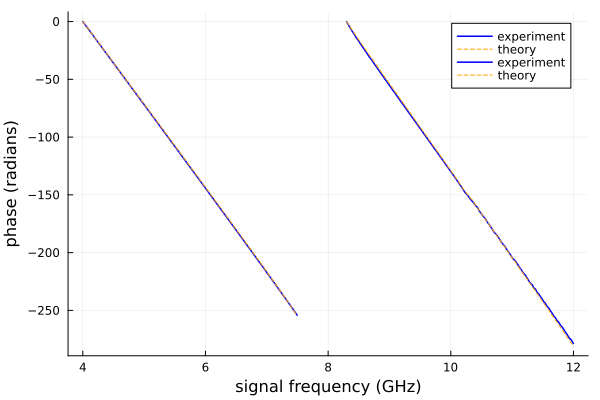

In [126]:
using DSP

plot(sigfreqs[861:end]/1.0e9,
    unwrap(angle.(undrivendata[861:end]./thru[861:end])) .- angle(undrivendata[861] / thru[861]),
    label="experiment",
    ylabel="phase (radians)", c=:blue,
    linewidth = 1.5)

plot!(w[431:end]/(2*pi*1e9),
     unwrap(angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                431:end])) .- angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                431]), ls=:dash,
    label="theory",c=:orange,
xlabel="signal frequency (GHz)")

plot!(sigfreqs[1:700]/1.0e9,
    unwrap(angle.(undrivendata[1:700]./thru[1:700])) .- angle(undrivendata[1] / thru[1]),
    label="experiment",
    ylabel="phase (radians)",c=:blue,
    linewidth = 1.5)

plot!(w[1:350]/(2*pi*1e9),
    unwrap(angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                1:350])) .- angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                1]),
    label="theory",ls=:dash,c=:orange,
xlabel="signal frequency (GHz)")

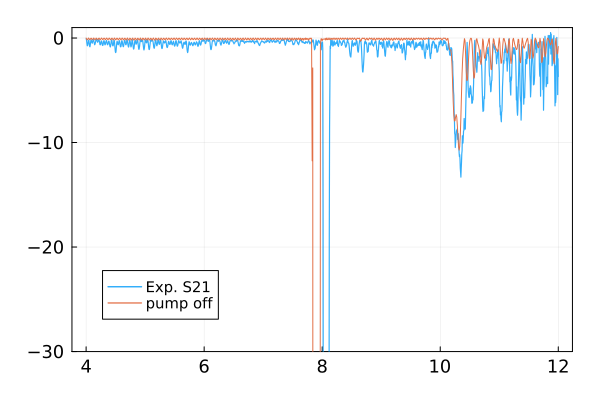

In [130]:

plot(sigfreqs[:]/1.0e9,
    10*log10.(abs2.(undrivendata[:]./thru[:])),
    label="Exp. S21",
    linewidth = 1.5,
    legend=(0.15,.2),
    margin=5mm,
#     bottom_margin=5mm,
    ;plotconfigs...)



plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,:])),
    label="pump off")

plot!(ylim=(-30,1))

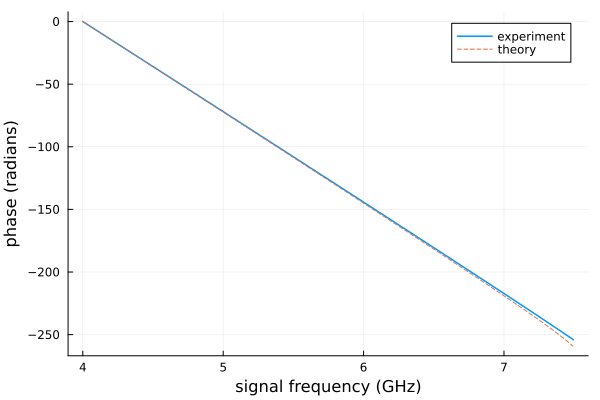

In [106]:
using DSP

plot(sigfreqs[1:700]/1.0e9,
    unwrap(angle.(undrivendata[1:700]./thru[1:700])) .- angle(undrivendata[1] / thru[1]),
    label="experiment",
    ylabel="phase (radians)",
    linewidth = 1.5)

plot!(w[1:350]/(2*pi*1e9),
    unwrap(angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                1:350])) .- angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,
                1]),
    label="theory",ls=:dash,
xlabel="signal frequency (GHz)")

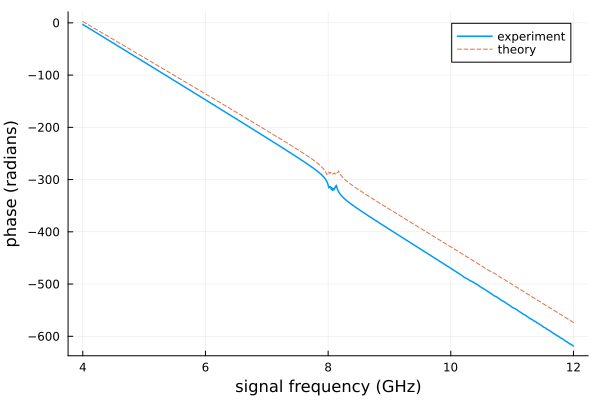

In [77]:
using DSP

plot(sigfreqs[:]/1.0e9,
    unwrap(angle.(undrivendata[:]./thru[:])),
    label="experiment",
    ylabel="phase (radians)",
    linewidth = 1.5)

plot!(w/(2*pi*1e9),
    unwrap(angle.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,:])),
    label="theory",ls=:dash,
xlabel="signal frequency (GHz)")

In [78]:
kb = 1.38e-23
hbar = 6.636e-34 / (2 * pi)
wscale = (2 * pi) * 1e9

function nBE(w, T)
    return 1/ (exp(hbar * w / (kb * T)) - 1)
end

wtarget = 6 * wscale

3.7699111843077515e10

In [67]:
hbar * wtarget / kb

0.2885217391304348

In [76]:
nBE(wtarget, 5)

16.834525125612746

In [74]:
kb * 2.5 / (hbar * wtarget) - 1/2 - nBE(wtarget, 5)

-8.669666777210093

In [77]:
hbar * wtarget / (kb * 2.5)

0.11540869565217389

In [79]:
kb * 2.5 / (hbar * wtarget)

8.664858348402653

 93.211142 seconds (42.06 M allocations: 14.358 GiB, 4.31% gc time)
  1.046070 seconds (1.80 M allocations: 541.814 MiB, 20.47% gc time)
 15.569386 seconds (4.20 M allocations: 7.966 GiB, 7.84% gc time)


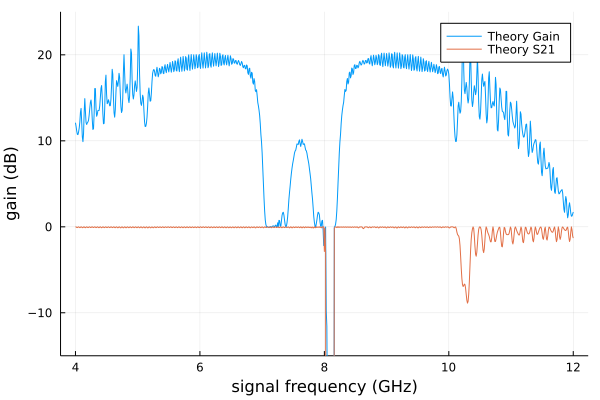

In [16]:
# define the circuit components
# circuit = []

circuit = Tuple{String,String,String,Num}[]

tandelta= 0#1e-5
Ljscale = 1.15
Cscale = 1.05 #/(1+im*tandelta)
Cgrscale = 0.4#/(1+im*tandelta)
Cjscale = 2.0#/(1+im*tandelta)

@variables Ipump Rleft Rright

# port on the left side
push!(circuit,("P$(1)_$(0)","1","0",1))
push!(circuit,("R$(1)_$(0)","1","0",Rleft))
Nj=p["L"]


# Nj=600
# use 8000 to get rid of the pmrs
pmrpitch = p["spacing"]
# pmrpitch = 16000
#first half cap to ground
push!(circuit,("Cg$(1)_$(0)","1","0",Cscale*p["Cgvals_raw_u"][1]/2))
#middle caps and jj's
push!(circuit,("Ls$(1)_$(2)","1","2",p["Lsu"]/2)) 
push!(circuit,("Lj$(2)_$(3)","2","3",Ljscale*p["Ljvals_raw"][1])) 
push!(circuit,("Lj$(3)_$(4)","3","4",Ljscale*p["Ljvals_raw"][1])) 
push!(circuit,("Lj$(4)_$(5)","4","5",Ljscale*p["Ljvals_raw"][1])) 

j=5
for i = 2:Nj-1

    superidx = i ÷ pmrpitch
    
    if superidx % p["vspacing"] == 0
        Ls = p["Lsv"]
        Cc = p["Cc_raw_v_between_left"][i]
        Cg = p["Cgvals_raw_v"][i]
        Cg_pmr = p["Cg_pmr_v_raw_left"][i]

    else
        Ls = p["Lsu"]
        Cc = p["Cc_raw_u_between_left"][i]
        Cg = p["Cgvals_raw_u"][i]
        Cg_pmr = p["Cg_pmr_u_raw_left"][i]
    end
    
#     if ispmr(i,pmrpitch)
    if mod(i,pmrpitch) == pmrpitch÷2 && abs(Cc) > 0

        # series linear inductor
        push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",Ls/2)) 
        
        # make the jj cell with modified capacitance to ground
        push!(circuit,("Cgr$(j+1)_$(0)","$(j+1)","$(0)",Cscale*Cg_pmr+Cgrscale*Cscale*p["Cgr"]))
        
        # series linear inductor
        push!(circuit,("Ls$(j+1)_$(j+2)","$(j+1)","$(j+2)",Ls/2)) 
        
        # make the pmr
        # coupling capacitor
        push!(circuit,("Cc$(j+2)_$(j+3)","$(j+2)","$(j+3)",Cscale*Cc))
        
        # series inductor
        push!(circuit,("Lc$(j+3)_$(j+4)","$(j+3)","$(j+4)",p["Lc"]))
        push!(circuit,("Cr$(j+4)_$(0)","$(j+4)","$(0)",Cscale*p["Cr"]))
        push!(circuit,("Lr$(j+4)_$(0)","$(j+4)","$(0)",p["Lr"]))
        
        # make the junctions
        push!(circuit,("Lj$(j+2)_$(j+5)","$(j+2)","$(j+5)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+5)_$(j+6)","$(j+5)","$(j+6)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+6)_$(j+7)","$(j+6)","$(j+7)",Ljscale*p["Ljvals_raw"][i])) 

        # make the junction capacitors
        push!(circuit,("Cj$(j+2)_$(j+5)","$(j+2)","$(j+5)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+5)_$(j+6)","$(j+5)","$(j+6)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+6)_$(j+7)","$(j+6)","$(j+7)",Cjscale*p["Cjvals_raw"][i])) 
        
        # increment the index by two because of the 2
        # pmr nodes.
        j+=2
    else
        
        # series linear inductor
        push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",Ls/2)) 

        # add capacitance to ground
        push!(circuit,("Cg$(j+1)_$(0)","$(j+1)","$(0)",Cscale*Cg))

        # series linear inductor
        push!(circuit,("Ls$(j+1)_$(j+2)","$(j+1)","$(j+2)",Ls/2)) 
        
        # add JJ
        push!(circuit,("Lj$(j+2)_$(j+3)","$(j+2)","$(j+3)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+3)_$(j+4)","$(j+3)","$(j+4)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+4)_$(j+5)","$(j+4)","$(j+5)",Ljscale*p["Ljvals_raw"][i]))

        # add the junction capacitance
        push!(circuit,("Cj$(j+2)_$(j+3)","$(j+2)","$(j+3)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+3)_$(j+4)","$(j+3)","$(j+4)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+4)_$(j+5)","$(j+4)","$(j+5)",Cjscale*p["Cjvals_raw"][i]))
    end
    # increment the index
    j+=5

end

#last jj
push!(circuit,("Cg$(j)_$(0)","$(j)","$(0)",p["Cgvals_raw_u"][end]/2))
push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",p["Lsu"]/2)) 

push!(circuit,("R$(j+1)_$(0)","$(j+1)","$(0)",Rright))
push!(circuit,("P$(j+1)_$(0)","$(j+1)","$(0)",2))

circuitdefs = Dict(
    Rleft => 60,
    Rright => 60,
)

w=2*pi*(4.0:0.01:12)*1e9
woff = 2*pi *(6.6:0.00001:6.8)*1e9
# wp=2*pi*7.901*1e9
wp=2*pi*7.620*1e9

# w=2*pi*[6.0]*1e9
# w=2*pi*(0.1:0.1:30)*1e9

# Nsignalmodes = 1
# Npumpmodes = 1

Npumpmodes = 10
Nsignalmodes = 10
Ip=2.0e-6*0.71#0.69
@time pumpon2 = hbsolve(w,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);

Npumpmodes = 1
Nsignalmodes = 1
Ip=2.0e-6*0.0
@time pumpoff2 = hbsolve(w,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);


Npumpmodes = 1
Nsignalmodes = 1
Ip=2.0e-6*0.0
@time pumpoff_fine2 = hbsolve(woff,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);

plot(w/(2*pi*1e9),
    10*log10.(abs2.(pumpon2.signal.S[end-pumpon2.signal.Nmodes+pumpon2.signal.signalindex,pumpon2.signal.signalindex,:])),
    ylim=(-15,25),
    xlabel="signal frequency (GHz)",
    ylabel="gain (dB)",
    label="Theory Gain")

plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoff2.signal.S[end-pumpoff2.signal.Nmodes+pumpoff2.signal.signalindex,pumpoff2.signal.signalindex,:])),
    label="Theory S21")

# plot!(w/(2*pi*1e9),
#     10*log10.(abs2.(rpm.signal.S[rpm.signal.signalindex,rpm.signal.signalindex,:])),
#     label="return loss")


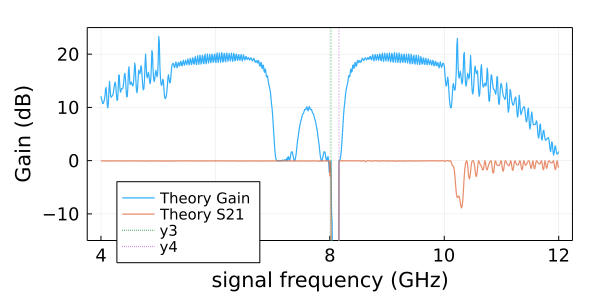

In [195]:
plot(w/(2*pi*1e9),
    10*log10.(abs2.(pumpon2.signal.S[end-pumpon2.signal.Nmodes+pumpon2.signal.signalindex,pumpon2.signal.signalindex,:])),
    ylim=(-15,25),
    xlabel="signal frequency (GHz)",
    ylabel="Gain (dB)",
    label="Theory Gain",
    size=(600,300),
    margin=5mm;
    plotconfigs...)

plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoff2.signal.S[end-pumpoff2.signal.Nmodes+pumpoff2.signal.signalindex,pumpoff2.signal.signalindex,:])),
    label="Theory S21",
    legend=(0.15,0.2)
    ;plotconfigs...)

# plot!(sigfreqs[:]/1.0e9,
#     10*log10.(abs2.(undrivendata[:]./thru[:])) .+ 2,
#     label="pump off exp",
#     linewidth = 1.5)


plot!([8.02], seriestype=:vline,ls=:dot)
plot!([8.16], seriestype=:vline,ls=:dot)

# savefig("Theory-Gain-Floquet-TWPA1_1.pdf")

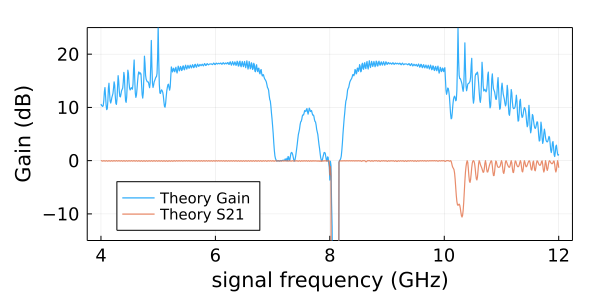

In [20]:

plot(w/(2*pi*1e9),
    10*log10.(abs2.(pumpon.signal.S[end-pumpon.signal.Nmodes+pumpon.signal.signalindex,pumpon.signal.signalindex,:])),
    ylim=(-15,25),
    xlabel="signal frequency (GHz)",
    ylabel="Gain (dB)",
    label="Theory Gain",
    size=(600,300);
    margin=5mm,
    plotconfigs...)

plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoff.signal.S[end-pumpoff.signal.Nmodes+pumpoff.signal.signalindex,pumpoff.signal.signalindex,:])),
    label="Theory S21",
    legend=(0.15,0.2)
    ;plotconfigs...)


# savefig("Theory-Gain-Floquet-TWPA1_1.pdf")

In [52]:
sqrt(1.15*1.05)

1.0988630487917956

100.001132 seconds (42.07 M allocations: 19.058 GiB, 3.37% gc time)
  0.942106 seconds (1.81 M allocations: 541.847 MiB)
 19.524896 seconds (4.21 M allocations: 7.966 GiB, 15.93% gc time)


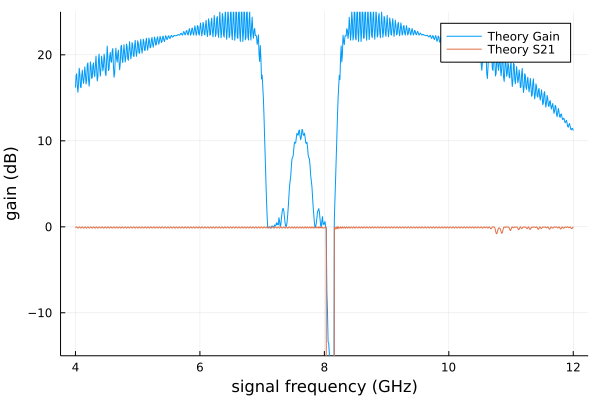

In [197]:
# define the circuit components
# circuit = []

circuit = Tuple{String,String,String,Num}[]

tandelta= 0#1e-5
Ljscale = 1.05
Cscale = 1.05 #/(1+im*tandelta)
Cgrscale = 1.0 #0.4#/(1+im*tandelta)
Cjscale = 1#2.0#/(1+im*tandelta)

@variables Ipump Rleft Rright

# port on the left side
push!(circuit,("P$(1)_$(0)","1","0",1))
push!(circuit,("R$(1)_$(0)","1","0",Rleft))
Nj=p["L"]


# Nj=600
# use 8000 to get rid of the pmrs
pmrpitch = p["spacing"]
# pmrpitch = 16000
#first half cap to ground
push!(circuit,("Cg$(1)_$(0)","1","0",Cscale*p["Cgvals_raw_u"][1]/2))
#middle caps and jj's
push!(circuit,("Ls$(1)_$(2)","1","2",p["Lsu"]/2)) 
push!(circuit,("Lj$(2)_$(3)","2","3",Ljscale*p["Ljvals_raw"][1])) 
push!(circuit,("Lj$(3)_$(4)","3","4",Ljscale*p["Ljvals_raw"][1])) 
push!(circuit,("Lj$(4)_$(5)","4","5",Ljscale*p["Ljvals_raw"][1])) 

j=5
for i = 2:Nj-1

    superidx = i ÷ pmrpitch
    

    Ls = p["Lsu"]
    Cc = p["Cc_raw_u_between_left"][i]
    Cg = p["Cgvals_raw_u"][i]
    Cg_pmr = p["Cg_pmr_u_raw_left"][i]
    
#     if ispmr(i,pmrpitch)
    if mod(i,pmrpitch) == pmrpitch÷2 && abs(Cc) > 0

        # series linear inductor
        push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",Ls/2)) 
        
        # make the jj cell with modified capacitance to ground
        push!(circuit,("Cgr$(j+1)_$(0)","$(j+1)","$(0)",Cscale*Cg_pmr+Cgrscale*Cscale*p["Cgr"]))
        
        # series linear inductor
        push!(circuit,("Ls$(j+1)_$(j+2)","$(j+1)","$(j+2)",Ls/2)) 
        
        # make the pmr
        # coupling capacitor
        push!(circuit,("Cc$(j+2)_$(j+3)","$(j+2)","$(j+3)",Cscale*Cc))
        
        # series inductor
        push!(circuit,("Lc$(j+3)_$(j+4)","$(j+3)","$(j+4)",p["Lc"]))
        push!(circuit,("Cr$(j+4)_$(0)","$(j+4)","$(0)",Cscale*p["Cr"]))
        push!(circuit,("Lr$(j+4)_$(0)","$(j+4)","$(0)",p["Lr"]))
        
        # make the junctions
        push!(circuit,("Lj$(j+2)_$(j+5)","$(j+2)","$(j+5)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+5)_$(j+6)","$(j+5)","$(j+6)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+6)_$(j+7)","$(j+6)","$(j+7)",Ljscale*p["Ljvals_raw"][i])) 

        # make the junction capacitors
        push!(circuit,("Cj$(j+2)_$(j+5)","$(j+2)","$(j+5)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+5)_$(j+6)","$(j+5)","$(j+6)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+6)_$(j+7)","$(j+6)","$(j+7)",Cjscale*p["Cjvals_raw"][i])) 
        
        # increment the index by two because of the 2
        # pmr nodes.
        j+=2
    else
        
        # series linear inductor
        push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",Ls/2)) 

        # add capacitance to ground
        push!(circuit,("Cg$(j+1)_$(0)","$(j+1)","$(0)",Cscale*Cg))

        # series linear inductor
        push!(circuit,("Ls$(j+1)_$(j+2)","$(j+1)","$(j+2)",Ls/2)) 
        
        # add JJ
        push!(circuit,("Lj$(j+2)_$(j+3)","$(j+2)","$(j+3)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+3)_$(j+4)","$(j+3)","$(j+4)",Ljscale*p["Ljvals_raw"][i])) 
        push!(circuit,("Lj$(j+4)_$(j+5)","$(j+4)","$(j+5)",Ljscale*p["Ljvals_raw"][i]))

        # add the junction capacitance
        push!(circuit,("Cj$(j+2)_$(j+3)","$(j+2)","$(j+3)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+3)_$(j+4)","$(j+3)","$(j+4)",Cjscale*p["Cjvals_raw"][i])) 
        push!(circuit,("Cj$(j+4)_$(j+5)","$(j+4)","$(j+5)",Cjscale*p["Cjvals_raw"][i]))
    end
    # increment the index
    j+=5

end

#last jj
push!(circuit,("Cg$(j)_$(0)","$(j)","$(0)",Cscale*p["Cgvals_raw_u"][end]/2))
push!(circuit,("Ls$(j)_$(j+1)","$(j)","$(j+1)",p["Lsu"]/2)) 

push!(circuit,("R$(j+1)_$(0)","$(j+1)","$(0)",Rright))
push!(circuit,("P$(j+1)_$(0)","$(j+1)","$(0)",2))

circuitdefs = Dict(
    Rleft => 60,
    Rright => 60,
)

w=2*pi*(4.0:0.01:12)*1e9
woff = 2*pi *(6.6:0.00001:6.8)*1e9
# wp=2*pi*7.901*1e9
wp=2*pi*7.620*1e9

# w=2*pi*[6.0]*1e9
# w=2*pi*(0.1:0.1:30)*1e9

# Nsignalmodes = 1
# Npumpmodes = 1

Npumpmodes = 10
Nsignalmodes = 10
Ip=2.0e-6*0.71 * 1.2#0.69
@time pumponideal = hbsolve(w,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);

Npumpmodes = 1
Nsignalmodes = 1
Ip=2.0e-6*0.0
@time pumpoffideal = hbsolve(w,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);


Npumpmodes = 1
Nsignalmodes = 1
Ip=2.0e-6*0.0
@time pumpoff_fine2 = hbsolve(woff,wp,Ip,Nsignalmodes,Npumpmodes,circuit,circuitdefs);

plot(w/(2*pi*1e9),
    10*log10.(abs2.(pumponideal.signal.S[end-pumponideal.signal.Nmodes+pumponideal.signal.signalindex,pumponideal.signal.signalindex,:])),
    ylim=(-15,25),
    xlabel="signal frequency (GHz)",
    ylabel="gain (dB)",
    label="Theory Gain")

plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoffideal.signal.S[end-pumpoffideal.signal.Nmodes+pumpoffideal.signal.signalindex,pumpoffideal.signal.signalindex,:])),
    label="Theory S21")

# plot!(w/(2*pi*1e9),
#     10*log10.(abs2.(rpm.signal.S[rpm.signal.signalindex,rpm.signal.signalindex,:])),
#     label="return loss")


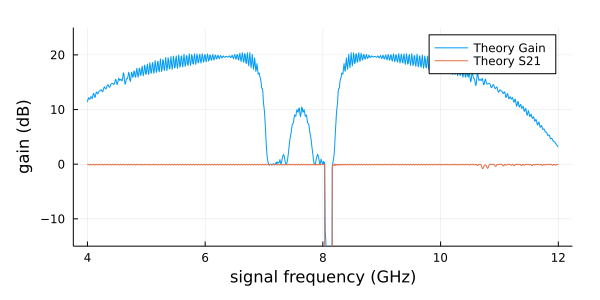

In [51]:
plot(w/(2*pi*1e9),
    10*log10.(abs2.(pumponideal.signal.S[end-pumponideal.signal.Nmodes+pumponideal.signal.signalindex,pumponideal.signal.signalindex,:])),
    ylim=(-15,25),
    size=(600,300),
    margin=5mm;
    xlabel="signal frequency (GHz)",
    ylabel="gain (dB)",
    label="Theory Gain")

plot!(w/(2*pi*1e9),
    10*log10.(abs2.(pumpoffideal.signal.S[end-pumpoffideal.signal.Nmodes+pumpoffideal.signal.signalindex,pumpoffideal.signal.signalindex,:])),
    label="Theory S21")


In [165]:
pumponideal.signal.QEideal

LoadError: MethodError: no method matching keys(::JosephsonCircuits.LinearHB)
[0mClosest candidates are:
[0m  keys([91m::Union{Tables.AbstractColumns, Tables.AbstractRow}[39m) at /Users/kaidongpeng/.julia/packages/Tables/PxO1m/src/Tables.jl:184
[0m  keys([91m::DataStructures.Accumulator[39m) at /Users/kaidongpeng/.julia/packages/DataStructures/59MD0/src/accumulator.jl:58
[0m  keys([91m::Missings.EachFailMissing[39m) at /Users/kaidongpeng/.julia/packages/Missings/r1STI/src/Missings.jl:154
[0m  ...

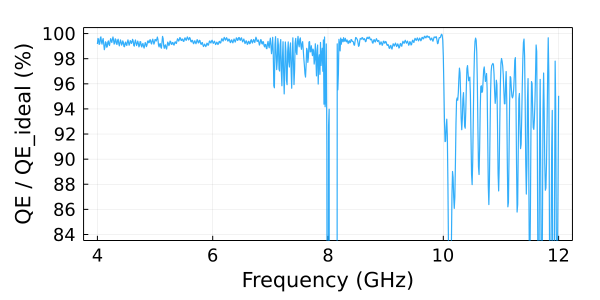

In [187]:

w=2*pi*(4.0:0.01:12)*1e9
plot(w/(2*pi*1e9),
    pumpon2.signal.QE[end-pumpon2.signal.Nmodes+pumpon2.signal.signalindex,pumpon2.signal.signalindex,:] ./
pumpon2.signal.QEideal[end-pumpon2.signal.Nmodes+pumpon2.signal.signalindex,pumpon2.signal.signalindex,:] .* 100;plotconfigs...)

plot!(xlabel="Frequency (GHz)";plotconfigs...)
plot!(ylabel="QE / QE_ideal (%)",size=(600,300),margin=5mm)
plot!(ylim=[84,100],yticks =84:2:100)
plot!(legend=nothing)


# savefig("Theory-QE-Floquet-TWPA1_1.pdf")

In [98]:
function to_dB(val::Number)
    return 20 * log10(val)
end
function from_dB(val::Number)
    return 10^(val/20)
end

function to_dBm(val::Number)
    return 10 * log10(abs(val) * 1e3)
end

function from_dBm(val::Number)
    return 10^(val / 10) *1e-3
end

function estimate_P1dB(Ic; Ipn=0.5, GdB=20, Z0=50)
    # Gdb is in dB
    G0 = from_dB(GdB)^2 # power gain in linear unit
    P1dB = (Ic * Ipn)^2 * Z0 / (2 * G0)
    return to_dBm(P1dB)
end


estimate_P1dB (generic function with 1 method)

In [65]:
function nBE(T;w=6 * 2 * pi * 1e9)
    hbar = 6.626e-34/ (2 * pi)
    k=1.38e-23
    return 1 / (exp(hbar * w / (k * T)) + 1)
end

function Acaves(T)
    return nBE(T) + 1/2
end

Acaves (generic function with 1 method)

In [132]:
function snron(etaval, Themt, GtwpadB, w; N1 = Acaves(20e-3))
    eta = etaval * 0.5
    A_isolator = from_dB(-0.2)^2 # all in power 
    G_TWPA = from_dB(GtwpadB)^2
    G_HEMT = from_dB(35)^2
    Acaves_HEMT = 1.38e-23 * (Themt) / (6.636e-34 / (2*pi) * w)

    S1 = 10 # arbitrary
    S2 = S1 * G_TWPA
    N2 = G_TWPA * (N1) / eta
    S3 = S2 * A_isolator
    N3 = A_isolator * N2 + (1-A_isolator) + Acaves(20e-3)
    S4 = S3 * G_HEMT
    N4= G_HEMT * (N3 + Acaves_HEMT)

    return S4/N4
 
end


snron (generic function with 3 methods)

In [152]:
Themt = 6
GtwpadB = 17.842 #18
eta= 0.95#0.95#0.98
w=6e9 * 2 * pi
N1 = 0.5#Acaves(20e-3)
to_dB(sqrt(snron(eta,Themt, GtwpadB,w,N1=N1) / snron(1, Themt,1, w,N1=N1)))



11.207463332872496

In [129]:
17.842 - 11.21

6.631999999999998

In [86]:
to_dB(sqrt(7.532527886819985 / 1.9217135041034312))

2.9662605309892207

In [92]:
to_dB(sqrt(7.532527886819985 / 1.9217135041034312))

2.9662605309892207

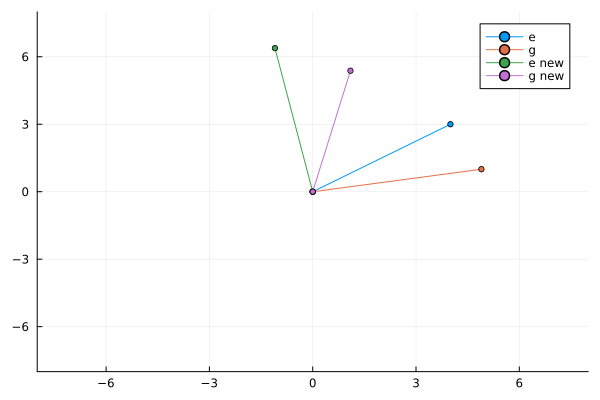

In [159]:
xe = 4
ye = 3
xg = sqrt(24)
yg = 1
# plot([xe],[ye],seriestype=:scatter)
theta = -atan((ye-yg)/(xe-xg))

xe_new = xe * cos(theta) - ye * sin(theta)
xg_new = xg * cos(theta) - yg * sin(theta)
ye_new = xe * sin(theta) + ye * sin(theta)
yg_new = xg * sin(theta) + yg * sin(theta)

plot([0,xe],[0,ye],marker=:circ,markersize=3,label="e")
plot!([0,xg],[0,yg],
    marker=:circ,markersize=3, label="g")


plot!([0,xe_new],[0,ye_new],
    marker=:circ,markersize=3, label="e new")

plot!([0,xg_new],[0,yg_new],
    marker=:circ,markersize=3, label="g new")



plot!(xlim=[-8,8], ylim=[-8,8])

In [ ]:
plot([0,xe],[0,ye],marker=:circ,markersize=3)
plot!([0,xg],[0,yg],
    marker=:circ,markersize=3)


plot!(xlim=[0,6], ylim=[0,6])

In [160]:
2^(31-15)

65536